## Sources
https://www.datascience.com/blog/python-anomaly-detection <br>
http://scikit-learn.org/stable/modules/outlier_detection.html <br>
https://www.kaggle.com/mlg-ulb/creditcardfraud/kernels <br>
https://github.com/Vicam/Unsupervised_Anomaly_Detection/blob/master/Anomaly%20detection%2C%20different%20methods%20on%20a%20simple%20example.ipynb<br>

Worth checking:<br>
https://lvdmaaten.github.io/tsne/<br>
https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-nowhttps://www.kaggle.com/currie32/predicting-fraud-with-tensorflow<br>


More theoretical:
https://link.springer.com/article/10.1007%2Fs10618-012-0300-z <br>




## Goal
The goal of this notebook is to perform <u> unsupervised </u> machine learning analysis that will indicate the anomalies. The goal is not to be able to detect fraud, yet it will be cross-checked with the fraud class.


## Plan
0. import packages and data
1. explore the data<br>
<strike>2. detect anomalies with simple statistics (mean and standard deviation) - resigned from this approach due to large dispersion</strike>
3. detect anomalies with slightly less simple statictics
4. KNN
5. LOF
6. K-Means
7. OneClassCVM
8. Deep-Learning?

## Other information
<li> EllipticEnvelope deprioritised due to the assumption of Gaussian distribution

In [32]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#imports for slightly less simple statisics
import collections
from itertools import count

#imports for knn



#load data
data = pd.read_csv("creditcard.csv")

    Time        V1        V2        V3        V4        V5        V6  \
0    0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1    0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2    1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3    1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4    2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
5    2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728   
6    4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708   
7    7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118   
8    7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818   
9    9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761   
10  10.0  1.449044 -1.176339  0.913860 -1.375667 -1.971383 -0.629152   
11  10.0  0.384978  0.616109 -0.874300 -0.094019  2.924584  3.317027   
12  10.0  1.249999 -1.221637  0.383930 -1.234899 -1.485419 -0.75

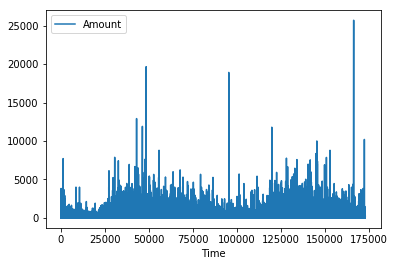

In [19]:
#inital exploration of data
print(data.head(25))
data.info() #no nulls, time coded as float as it's the seconds from hour 0
print(data.describe())
data.plot(x='Time', y='Amount')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1,0.12,-0.011,-0.42,-0.11,0.17,-0.063,0.085,-0.037,-0.0087,0.031,-0.25,0.12,-0.066,-0.099,-0.18,0.012,-0.073,0.09,0.029,-0.051,0.045,0.14,0.051,-0.016,-0.23,-0.041,-0.0051,-0.0094,-0.011,-0.012
V1,0.12,1,4.7e-17,-1.4e-15,1.8e-17,6.4e-17,2.4e-16,2e-15,-9.5e-17,2.2e-16,7.4e-17,2.4e-16,2.4e-16,-2.1e-16,9.4e-16,-3.3e-16,6.3e-16,-5e-16,2.9e-16,1.8e-16,1e-16,-1.8e-16,7.5e-17,9.8e-16,7.4e-17,-9.8e-16,-8.6e-17,3.2e-17,9.8e-16,-0.23,-0.1
V2,-0.011,4.7e-17,1,2.5e-16,-1.1e-16,-2e-16,5e-16,4e-16,-4.4e-17,-5.7e-17,-4.8e-16,9.5e-16,-6.6e-16,3.9e-16,-2.5e-16,2.8e-16,4.9e-17,-9.9e-16,2.6e-16,9.5e-17,-9.3e-16,8.4e-17,2.5e-16,1.1e-16,-8.1e-18,-4.3e-17,2.6e-16,-4.5e-16,-3.7e-16,-0.53,0.091
V3,-0.42,-1.4e-15,2.5e-16,1,-3.4e-16,-1.4e-15,1.4e-15,2.2e-15,3.4e-16,-4.2e-16,6.3e-16,-5.5e-17,2.2e-16,-6.9e-16,4.3e-16,1.1e-16,1.2e-15,4.6e-17,5.4e-16,2.6e-16,-9.4e-16,-3e-17,4.6e-16,2.1e-17,-9.4e-17,4.8e-16,6.5e-16,6.2e-16,7.7e-16,-0.21,-0.19
V4,-0.11,1.8e-17,-1.1e-16,-3.4e-16,1,-1.9e-15,-2.7e-16,1.6e-16,5.2e-16,3.9e-16,6.1e-16,-2.1e-16,-5.7e-16,-1.5e-16,-8.5e-17,-1.5e-16,-6.9e-16,-4.4e-16,1.5e-16,-2.7e-16,-3.2e-16,-1e-16,2.1e-16,6e-17,2.2e-16,5.4e-16,-6.2e-16,-6.4e-17,-5.9e-17,0.099,0.13
V5,0.17,6.4e-17,-2e-16,-1.4e-15,-1.9e-15,1,7.9e-16,-4.2e-16,7.6e-16,4.2e-16,-6.6e-16,7.3e-16,3.8e-16,-9.6e-16,-3.6e-16,-5.1e-16,-3.5e-16,1.4e-16,1.1e-15,-3.1e-16,2.1e-16,-1.4e-16,5.1e-16,1.6e-16,-9.3e-16,5.6e-16,9.1e-16,4.5e-16,-3.3e-16,-0.39,-0.095
V6,-0.063,2.4e-16,5e-16,1.4e-15,-2.7e-16,7.9e-16,1,1.4e-16,-1.7e-16,1.1e-16,2.9e-16,4.9e-16,2.1e-16,-2.3e-16,3.5e-16,-6.4e-18,-2.5e-16,3.6e-16,2.8e-16,2.7e-16,1.9e-16,-1.6e-16,-3.4e-16,-7.2e-17,-1.3e-15,1.1e-15,-2.4e-16,-2.6e-16,4.8e-16,0.22,-0.044
V7,0.085,2e-15,4e-16,2.2e-15,1.6e-16,-4.2e-16,1.4e-16,1,-8.7e-17,7.9e-16,3e-17,-1.1e-15,1.5e-15,-9.9e-17,-1.7e-16,1.9e-17,2.9e-16,1.1e-15,-1.1e-16,-2.9e-16,1.7e-16,1.9e-16,-1.1e-15,2.3e-16,-2.6e-17,1.2e-15,-7.3e-16,-5.9e-16,-6.8e-17,0.4,-0.19
V8,-0.037,-9.5e-17,-4.4e-17,3.4e-16,5.2e-16,7.6e-16,-1.7e-16,-8.7e-17,1,2.9e-16,9.1e-17,2e-16,-6.3e-17,-2.4e-16,-1.1e-16,2e-16,5e-16,-3.5e-16,-4.1e-16,-5.3e-16,-1.1e-16,-2.4e-16,5.5e-16,3.9e-16,-1.8e-16,-1.4e-16,-1.2e-16,1.7e-16,-4.5e-16,-0.1,0.02
V9,-0.0087,2.2e-16,-5.7e-17,-4.2e-16,3.9e-16,4.2e-16,1.1e-16,7.9e-16,2.9e-16,1,-2.8e-16,4.7e-16,-2.4e-15,-2.7e-16,2.3e-16,-1.6e-15,-3.3e-16,6.5e-16,1.2e-16,1.1e-16,-4.3e-16,4.6e-17,2.9e-17,5.9e-16,-2.3e-16,1.1e-15,-1.4e-15,-2.3e-16,9.1e-16,-0.044,-0.098


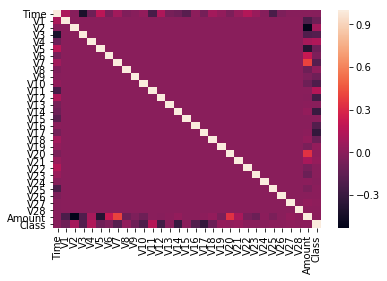

In [16]:

#show the correlation matrix
rs = np.random.RandomState(0)
corr = data.corr()
corr.style.background_gradient().set_precision(2)


#prepare the heatmap for an overview
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


## 2. Slightly less simple statistics
Source: https://www.datascience.com/blog/python-anomaly-detection

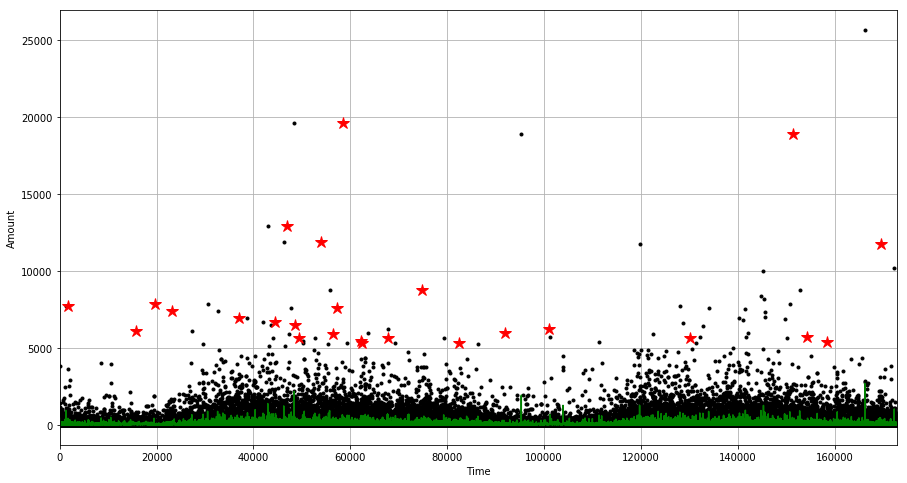

Information about the anomalies model:{'standard_deviation': 222.748, 'anomalies_dict': OrderedDict([(1632, 7712.43), (15835, 6130.21), (19760, 7879.42), (23128, 7429.15), (37000, 6950.51), (44513, 6669.0), (46841, 12910.93), (48529, 6511.0), (49406, 5680.0), (54018, 11898.09), (56335, 5934.9), (57209, 7636.3), (58465, 19656.53), (67724, 5657.54), (74699, 8790.26), (91896, 6000.0), (100954, 6239.54), (151296, 18910.0), (154316, 5707.82), (169457, 11789.84), (175710, 5918.0), (188560, 7766.6), (190137, 6652.89), (197735, 5714.58), (199032, 6454.74), (201638, 7583.32), (216065, 6982.67), (217781, 6828.0), (218985, 7541.7), (219530, 5714.2), (220090, 5964.95), (226690, 8360.0), (227921, 10000.0), (228158, 8182.7), (228525, 6998.0), (228723, 7367.0), (238412, 6900.47), (239532, 5627.06), (240739, 7862.39), (245474, 8787.0), (274769, 8.97), (274770, 0.76), (274771, 25691.16), (274772, 0.77), (274773, 91.78), (284249, 10199.44)])}


In [52]:
def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 172792)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

   # print(events)
   # print(events['anomalies_dict'].items())
   # print(events['anomalies_dict'].values())
    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=float, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()
    
# 4. Lets play with the functions
x = data['Time']
y = data['Amount']

# plot the results
plot_results(x, y=y, window_size=10, text_xlabel="Time", sigma_value=20,
             text_ylabel="Amount")
events = explain_anomalies(y, window_size=5, sigma=20)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))



## Comment on the above
To be checked whether there's any overlap between the above outliers and the fraud observations. <br>
It's apparent that there's some shift in the plot between the outliers flag (stars) and the actual data points)

## KNN - this section is to be ignored for now as I don't see how I can use it
In one of the sources it was used, yet it's a classification method.

In [65]:
#import packages for knn
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Feature Scaling - although the features starting with V seem to be scaled, why not scale them again?
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
analysis_data = sc.fit_transform(X)



analysis_data = data.iloc[:, :-1]
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(analysis_data)
#print(analysis_data)

## what comes next?

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)


## K-means

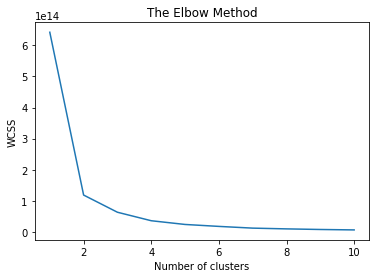

In [67]:
X = analysis_data
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [68]:
#fitting the data. Decision - 4 is the number of clusters

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [77]:
analysis_data['cluster'] = kmeans.predict(X)


In [78]:
print(analysis_data['cluster'].value_counts())

2    84331
0    69080
1    67973
3    63423
Name: cluster, dtype: int64


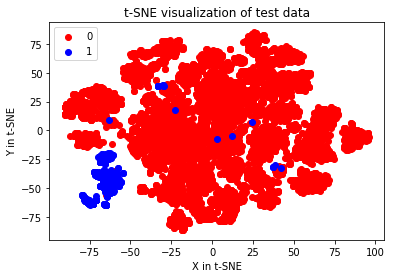

In [81]:
#seems that none of the clusters contain visibly more fraudulent transactions
#for i, j in zip(cluster, data.iloc[:, -1]):
#    if j == 1:
#        print(i, j)


#based on https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow

from sklearn.manifold import TSNE


tsne_data = pd.read_csv("creditcard.csv")

#Set df2 equal to all of the fraulent and 10,000 normal transactions.
df2 = tsne_data[tsne_data.Class == 1]
df2 = pd.concat([df2, tsne_data[tsne_data.Class == 0].sample(n = 10000)], axis = 0)


#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

#Set y equal to the target values.
y = df2.iloc[:,-1].values

tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)


#Build the scatter plot with the two types of transactions.
color_map = {0:'red', 1:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()